# PL611-Lazy analysis of initial land survey

The first order of business is to read the CSV file containing the ETRS89 measurements of the surface of the Lazy station.

In [1]:
%pylab inline
import csv

def read_etrs_csv(csv_name, delimiter=','):
    with open(csv_name, 'r') as csv_file:
        csv_rows = [(row[0], array([float(num) for num in row[1:4]])) 
                    for row in csv.reader(csv_file, delimiter=delimiter)
                    if 'ETRS' not in row[1]]
    names = [row[0] for row in csv_rows]
    positions = array([row[1] for row in csv_rows])
    return names, positions

with open('pl611-lazy-raw-surface-etrs-20141022.txt', 'r') as csv_file:
    csv_rows = [(row[0], array([float(num) for num in row[1:4]])) 
                for row in csv.reader(csv_file, delimiter=',')
                if 'ETRS' not in row[1]]
print(len(csv_rows))
csv_rows[0:3]

Populating the interactive namespace from numpy and matplotlib
73


[('1', array([ 3850923.499,  1439108.387,  4860505.308])),
 ('2', array([ 3850926.738,  1439093.313,  4860507.577])),
 ('3', array([ 3850929.972,  1439077.968,  4860510.536]))]

It seems like we succeeded in reading the file. The variable *position_dict* can be used to look up positions based on the name of the point. *all_positions* is an array of all 3D ETRS coordinates, and *all_names* holds the corresponding names.

In [2]:
position_dict = dict(csv_rows)
all_positions = array([row[1] for row in csv_rows])
all_names = [row[0] for row in csv_rows]

#border_names = ['10', '59', '43', '1' ]
#border_pos_etrs = array([position_dict[name] for name in border_names])

border_names = ['REF_NW', 'REF_NE', 'REF_SE', 'REF_SW']
border_pos_etrs = array([
    [ 3850963.43091107,  1438972.73686714,  4860517.80481272],
    [ 3850935.69297659,  1439106.25345331,  4860494.22075393],
    [ 3850996.1796777 ,  1439089.43361229,  4860446.36016848],
    [ 3851021.83304835,  1438956.18327832,  4860476.16247287]])

print(border_pos_etrs)
mean_position = all_positions.mean(axis=0)
print('Mean position (ETRS89): ', mean_position)

[[ 3850963.43091107  1438972.73686714  4860517.80481272]
 [ 3850935.69297659  1439106.25345331  4860494.22075393]
 [ 3850996.1796777   1439089.43361229  4860446.36016848]
 [ 3851021.83304835  1438956.18327832  4860476.16247287]]
Mean position (ETRS89):  [ 3850975.8870274   1439039.85309589  4860485.02369863]


And in geographic coordinates in radians and meters:

In [3]:
from lofargeo import *
geo_mean = geographic_from_xyz(mean_position)
print('''lat_rad : %(lat_rad).10f rad
lon_rad : %(lon_rad).10f rad
height_m: %(height_m).3f m''' % geo_mean)

lat_rad : 0.8720475738 rad
lon_rad : 0.3576145449 rad
height_m: 293.393 m


The normal vector to the WGS84 ellipsoid is then

In [4]:
ellipsoid_normal = normal_vector_ellipsoid(geo_mean['lon_rad'], geo_mean['lat_rad'])
repr(ellipsoid_normal)

'array([ 0.602564  ,  0.22516724,  0.76564766])'

## Slope of the field and selection of subset of points

The first inspection of the data is done with respect to the plane parallel to the tangent plane of the WGS84 ellipsoid at the mean position of all measured points, that goes right through the mean coordinate of all measured points. We determine a transformation_matrix that ensures that transformed "x" will be pointing east, "y" towards geographic north, and "z" up and perpendicular to the tangent plane of the ellipsoid at the longitude and latitude of the mean position.

In [5]:
local_north_projection = projection_matrix(mean_position, ellipsoid_normal)
local_north_xyz = transform(all_positions, mean_position, local_north_projection.T)

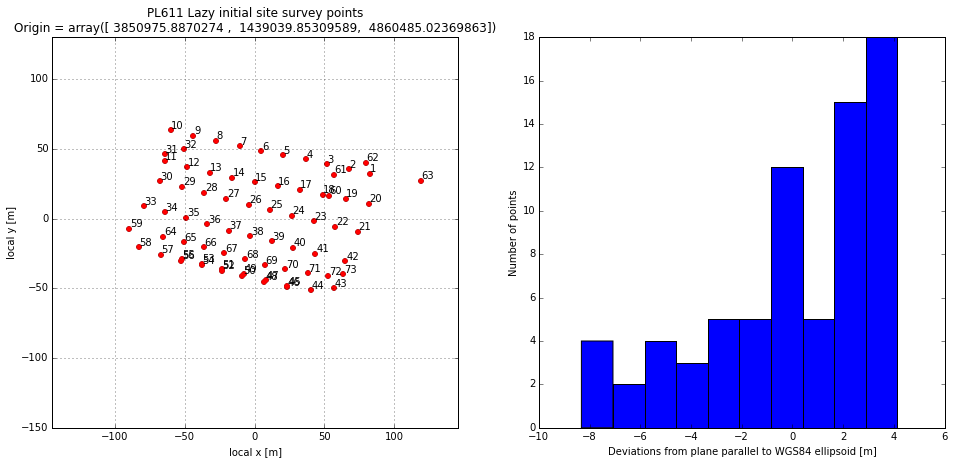

In [6]:
figure(figsize=(16,7))
subplot(121)
scatter(local_north_xyz[:,0], local_north_xyz[:,1])
for name, offset in zip(all_names, local_north_xyz):
    text(offset[0]+1, offset[1]+1
         , name)
axis('equal')
grid()
ylim(-150, +130)

title('PL611 Lazy initial site survey points\nOrigin = %r' %
      mean_position)
xlabel('local x [m]')
ylabel('local y [m]')

max_y = 500.0
min_y = -500.0
min_x = -500.0
max_x = +500.0
selection_xyz = array([xyz for xyz in local_north_xyz
                      if xyz[0] > min_x and xyz[0] < max_x 
                      and xyz[1]> min_y and xyz[1] < max_y])
selection_etrs = array([etrs for etrs, xyz in zip(all_positions, local_north_xyz)
                      if xyz[0] > min_x and xyz[0] < max_x
                      and xyz[1]> min_y and xyz[1] < max_y])
scatter(selection_xyz[:,0], selection_xyz[:,1], color='red')

subplot(122)
hist(selection_xyz[:,2], bins=10)
xlabel('Deviations from plane parallel to WGS84 ellipsoid [m]')
ylabel('Number of points')

The red points (the ones in the *selection_xyz* and *selection_etrs* variables) are used to fit the best fit plane to the station. *The histogram clearly shows that these points are not actual measurements*!

In [7]:
print ('The selection contains %d points.' % len(selection_etrs))

The selection contains 73 points.


The following function interpolates between unstructured points in 3D space.

In [8]:
from scipy.interpolate import Rbf # Radial basis function interpolation.
def interpolation_function(pqr):
    '''
    Return an interpolation function fn(x, y, z), which returns the value at x, y, 0.
    Make sure to pass an array of zeros the same shape as the x and y arrays.
    '''
    rbfi = Rbf(pqr[:,0], pqr[:,1], 0.0*pqr[:,2], pqr[:,2], function='linear')
    return rbfi

In [9]:
xyz_interpol_fn = interpolation_function(selection_xyz)
x_m, y_m = meshgrid(arange(-120, 150), arange(-100,100))
z_m = xyz_interpol_fn(x_m, y_m, 0.0*y_m)

Now let's plot a map of elevation of the selection relative to the mean position of all points.

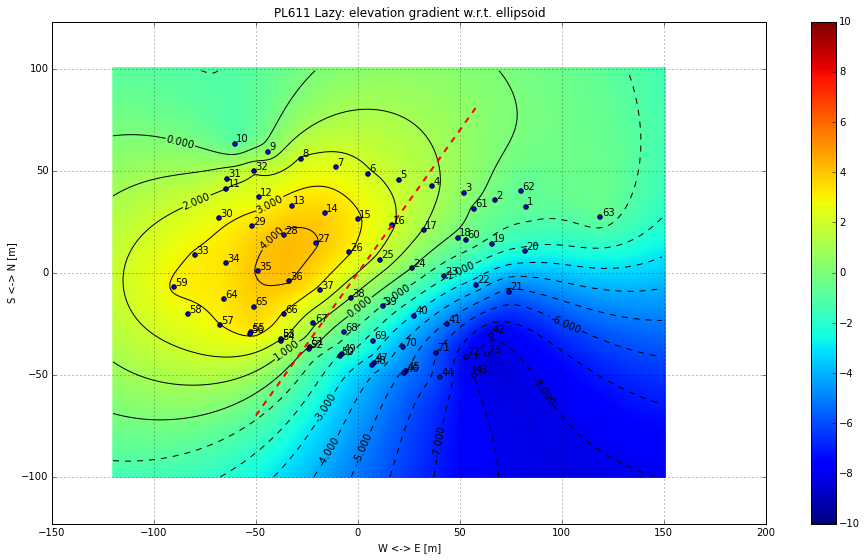

In [10]:
figure(figsize=(16,9))
imshow(z_m, origin='lower', vmin=-10, vmax=10, extent=(-120.5, 150.5, -100.5, 100.5))
colorbar()
cnt = contour(x_m, y_m, z_m, levels=arange(-10, 10,1.0), colors='black')
cnt.clabel(inline=True)
for name, offset in zip(all_names, local_north_xyz):
    text(offset[0]+1, offset[1]+1
         , name)
xlabel('W <-> E [m]')
ylabel('S <-> N [m]')
axis('equal')
grid()
title('PL611 Lazy: elevation gradient w.r.t. ellipsoid')
scatter(selection_xyz[:,0], selection_xyz[:,1])

def hba_lba_border(x):
    a = 1.4
    b = 0
    return a*x+b
hl_xx = arange(-50, 60)
plot(hl_xx, hba_lba_border(hl_xx), lw=2, color='red', ls='--')

The slope of the field with respect to the ellipsoid looks like the contours in Lazy6-3D.dwg, inspiring confidence that this time the coordinates indeed make sense.

## Best fit planes and deviations from that plane

We first need to separate the field measurements into HBA and LBA points:

In [11]:
lba_measurement_names = [name for name, xyz in zip(all_names, selection_xyz) if xyz[1] < hba_lba_border(xyz[0])]
lba_measurement_etrs = array([position_dict[name] for name in lba_measurement_names])

hba_measurement_names = [name for name, xyz in zip(all_names, selection_xyz) if xyz[1] >=hba_lba_border(xyz[0])]
hba_measurement_etrs = array([position_dict[name] for name in hba_measurement_names])
print(lba_measurement_names)
print(hba_measurement_names)

['1', '2', '3', '4', '17', '18', '19', '20', '21', '22', '23', '24', '25', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '60', '61', '62', '63', '68', '69', '70', '71', '72', '73']
['5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '53', '54', '55', '56', '57', '58', '59', '64', '65', '66', '67']


In [12]:
from numpy.linalg import lstsq

def fit_plane(xyz):
    # data_model z = ax +by +c
    # M colvec(a, b, c) = colvec(z)
    # M row i = (x_i, y_i, 1.0)
    mean_position = xyz.mean(axis=0)
    mat = array([xyz[:,0]- mean_position[0],
                 xyz[:,1]- mean_position[1],
                 ones(len(xyz[:,2]))]).T
    a, b, c = lstsq(mat, xyz[:,2] - mean_position[2])[0]
    normal_vector = array([-a, -b, 1.0])
    normal_vector /= norm(normal_vector)
    return {'mean': mean_position, 'normal': normal_vector}

In [13]:
solution_hba = fit_plane(hba_measurement_etrs)
rotation_matrix_hba = projection_matrix(LOFAR_XYZ0_m, solution_hba['normal'])
print('HBA Normal vector: ', repr(solution_hba['normal']))
print('HBA Mean position: ', repr(solution_hba['mean']))
print('HBA Rotation matrix:\n', repr(rotation_matrix_hba))

HBA Normal vector:  array([ 0.59170401,  0.21825049,  0.77604967])
HBA Mean position:  array([ 3850982.29377143,  1438999.50405714,  4860495.32702857])
HBA Rotation matrix:
 array([[-0.20817959, -0.77881167,  0.59170401],
       [ 0.97137103, -0.09383517,  0.21825049],
       [-0.11445339,  0.62019943,  0.77604967]])


In [14]:
solution_lba = fit_plane(lba_measurement_etrs)
rotation_matrix_lba = projection_matrix(LOFAR_XYZ0_m, solution_lba['normal'])
print('LBA Normal vector: ', repr(solution_lba['normal']))
print('LBA Mean position: ', repr(solution_lba['mean']))
print('LBA Rotation matrix:\n', repr(rotation_matrix_lba))

LBA Normal vector:  array([ 0.64556462,  0.31450813,  0.6959389 ])
LBA Mean position:  array([ 3850969.98607895,  1439077.01668421,  4860475.53378947])
LBA Rotation matrix:
 array([[-0.27916515, -0.71085381,  0.64556462],
       [ 0.94538309, -0.08564726,  0.31450813],
       [-0.16827846,  0.69810558,  0.6959389 ]])


In [15]:
station_pqr_hba = transform(selection_etrs, solution_hba['mean'], rotation_matrix_hba.T)
station_pqr_lba = transform(selection_etrs, solution_lba['mean'], rotation_matrix_lba.T)
station_height_deviation_fn_hba = interpolation_function(station_pqr_hba)
station_height_deviation_fn_lba = interpolation_function(station_pqr_lba)
print('HBA p range: ', station_pqr_hba[:,0].min(),'--', station_pqr_hba[:,0].max())
print('HBA q range: ', station_pqr_hba[:,1].min(),'--', station_pqr_hba[:,1].max())
print('LBA p range: ', station_pqr_lba[:,0].min(),'--', station_pqr_lba[:,0].max())
print('LBA q range: ', station_pqr_lba[:,1].min(),'--', station_pqr_lba[:,1].max())

HBA p range:  -45.3318977839 -- 153.492882487
HBA q range:  -49.4113392413 -- 48.8542988553
LBA p range:  -125.908218508 -- 74.1436516728
LBA q range:  -39.4729938271 -- 58.2583887377


In [16]:
p_m_hba, q_m_hba = meshgrid(arange(-50, 155), arange(-50, 50))
r_m_hba = station_height_deviation_fn_hba(p_m_hba, q_m_hba, 0.0*q_m_hba)

p_m_lba, q_m_lba = meshgrid(arange(-130, 75), arange(-40, 60))
r_m_lba = station_height_deviation_fn_hba(p_m_lba, q_m_lba, 0.0*q_m_lba)

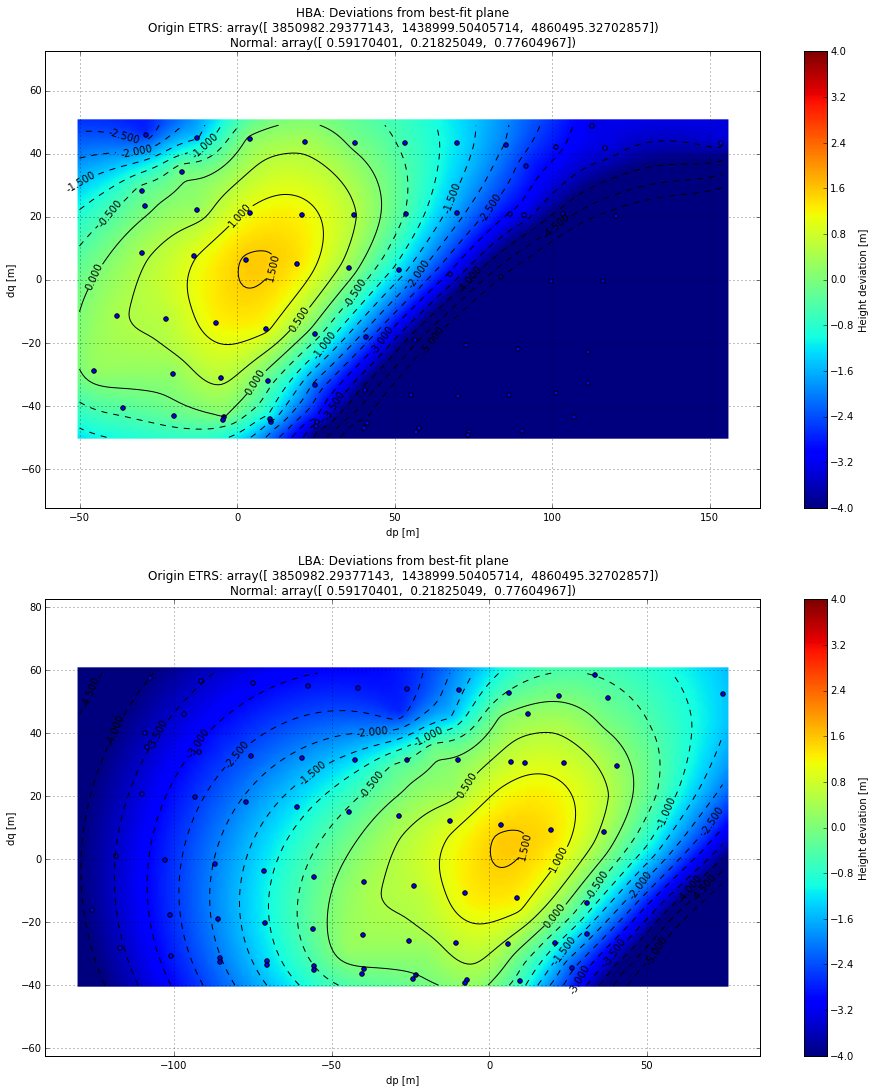

In [17]:
figure(figsize=(16, 18))
subplot(211)
imshow(r_m_hba, origin='lower', extent=(-50.5, 155.5, -50.5, 50.5), vmin=-4, vmax=+4)
axis('equal')
grid()
cb = colorbar()
cb.set_label('Height deviation [m]')
cnt = contour(p_m_hba, q_m_hba, r_m_hba, levels=arange(-5, 5, 0.5), colors='black')
cnt.clabel(inline=True)
title('''HBA: Deviations from best-fit plane
Origin ETRS: %r\nNormal: %r'''
#CHBA_ETRS = (%.3f, %.3f, %.3f)
#CLBA_ETRS = (%.3f, %.3f, %.3f)'''
%
      (solution_hba['mean'], solution_hba['normal']))#,
       #CHBA_ETRS[0], CHBA_ETRS[1], CHBA_ETRS[2],
       #CLBA_ETRS[0], CLBA_ETRS[1], CLBA_ETRS[2]))
xlabel('dp [m]')
ylabel('dq [m]')
scatter(station_pqr_hba[:,0], station_pqr_hba[:,1])

subplot(212)
imshow(r_m_lba, origin='lower', extent=(-130.5, 75.5, -40.5, 60.5), vmin=-4, vmax=+4)
axis('equal')
grid()
cb = colorbar()
cb.set_label('Height deviation [m]')
cnt = contour(p_m_lba, q_m_lba, r_m_lba, levels=arange(-5, 5, 0.5), colors='black')
cnt.clabel(inline=True)
title('''LBA: Deviations from best-fit plane
Origin ETRS: %r\nNormal: %r'''
#CHBA_ETRS = (%.3f, %.3f, %.3f)
#CLBA_ETRS = (%.3f, %.3f, %.3f)'''
%
      (solution_hba['mean'], solution_hba['normal']))#,
       #CHBA_ETRS[0], CHBA_ETRS[1], CHBA_ETRS[2],
       #CLBA_ETRS[0], CLBA_ETRS[1], CLBA_ETRS[2]))
xlabel('dp [m]')
ylabel('dq [m]')
scatter(station_pqr_lba[:,0], station_pqr_lba[:,1])

#chba_pqr = transform([CHBA_ETRS], solution['mean'], rotation_matrix.T)[0]
#scatter(chba_pqr[0], chba_pqr[1], color='red', s=40, marker='x')
#text(chba_pqr[0]+3, chba_pqr[1], 'CHBA', color='red')
#clba_pqr = transform([CLBA_ETRS], solution['mean'], rotation_matrix.T)[0]
#scatter(clba_pqr[0], clba_pqr[1], color='red', s=40, marker='x')
#text(clba_pqr[0]+3, clba_pqr[1], 'CLBA', color='red')


## Reference directions

The reference direction is the northern bisector of the X- and Y- dipoles. It is the second column of the rotation matrix. At LOFAR core station CS002 LBA, the reference direction coincides with true north, but elsewhere there is a slight deviation to ensure that all dipoles in LOFAR are oriented as similarly as possible. In this section, I determine the deviation between the reference direction (the "q" axis) and geographic north in the ETRS89 reference system.

In [18]:
ref_dir_hba = rotation_matrix_hba[:,1] 
print('HBA Reference direction of mean plane (q direction in ETRS89): ', ref_dir_hba)
ref_dir_lba = rotation_matrix_lba[:,1] 
print('LBA Reference direction of mean plane (q direction in ETRS89): ', ref_dir_lba)

HBA Reference direction of mean plane (q direction in ETRS89):  [-0.77881167 -0.09383517  0.62019943]
LBA Reference direction of mean plane (q direction in ETRS89):  [-0.71085381 -0.08564726  0.69810558]


To determine the angle between the reference direction of the station and ETRS89 north, we need to project the reference direction onto the tangent plane to the ellipsoid at the mean position of the field, and compute the normalized inner product between the "reference direction" of the local north frame and the projected reference direction.

In [19]:
def refdir_rad(mean_position_etrs, refdir_vector):
    tip_refdir = mean_position_etrs+refdir_vector
    projected_tip_ref_dir = transform(array([tip_refdir]), mean_position_etrs,
                                      local_north_projection.T)[0]
    projected_tip_ref_dir[2] = 0.0
    projected_tip_ref_dir = dot(local_north_projection, projected_tip_ref_dir)
    projected_tip_ref_dir /= norm(projected_tip_ref_dir)

    etrs_north = local_north_projection[:,1]
    deviation = arccos(inner(etrs_north, projected_tip_ref_dir))
    return deviation


In [20]:
print ('Reference direction for PL611-Lazy-HBA is %.4f degrees east from north.' %
       (refdir_rad(solution_hba['mean'], ref_dir_hba)*180/pi,))
print ('Reference direction for PL611-Lazy-LBA is %.4f degrees east from north.' %
       (refdir_rad(solution_lba['mean'], ref_dir_lba)*180/pi,))

Reference direction for PL611-Lazy-HBA is 10.6459 degrees east from north.
Reference direction for PL611-Lazy-LBA is 9.7436 degrees east from north.


### HBA and LBA centres

HBA and LBA centres can only be determined as soon as the ETRS coordinates of four reference points, preferably the corners of the field, have been provided. Fortunately, they are now known.

In [21]:
def square_corners(width, angle_rad=0.0):
    rot_mat = array([[cos(angle_rad), -sin(angle_rad)],
                     [sin(angle_rad), cos(angle_rad)]])
    corners = array([[-1, 1.0],[1.0, 1.0],[1.0, -1.0],[-1.0, -1.0],[-1.0, 1.0]])*width/2.0
    return array([dot(rot_mat, point) for point in corners])

def rectangle(width, height, angle_rad=0.0):
    rot_mat = array([[cos(angle_rad), -sin(angle_rad)],
                     [sin(angle_rad), cos(angle_rad)]])
    corners = array([[-width, height],[+width, height],[+width, -height],[-width, -height],[-width, +height]])/2.0
    return array([dot(rot_mat, point) for point in corners])

CABINET_WIDTH= 7.5
CABINET_HEIGHT= 3.5

HBA_CIRCLE_DIAMETER = 46.0 #62.0 
LBA_CIRCLE_DIAMETER = 75.0

def circle_points(diameter_m, num_points=100):
    phases = arange(0.0, 2*pi+2*pi/(2*num_points), 2*pi/(num_points-1))
    x = cos(phases)*diameter_m/2.0
    y = sin(phases)*diameter_m/2.0
    return concatenate([x.reshape((num_points, 1)), y.reshape((num_points, 1))], axis=1)

In [22]:
CHBA_ETRS = transform(array([[-4+5.9444-7,6+5.2589-8,0.6]]), zeros(3), rotation_matrix_hba)[0]+solution_hba['mean']
CLBA_ETRS = transform(array([[-8-9.25,9.8-9.40,-0.3]]), zeros(3), rotation_matrix_lba)[0]+solution_lba['mean']

#container_names = ['NW', 'SW', 'SE', 'NE']
#container_pqr_hba = array([
#    [33.9812, 32.5073, 0.0],
#    [33.7371, 29.0158, 0.0],
#    [41.2188, 28.4927, 0.0],
#    [41.4629, 31.9842, 0.0]]) - array([+5.9444, +5.2589, 0.0])[newaxis, :]
#container_etrs = transform(container_pqr_hba, zeros(3), rotation_matrix_hba) + CHBA_ETRS[newaxis,:]

container_names = ['CNT_NW', 'CNT_SW', 'CNT_SE', 'CNT_NE']
#container_etrs = array([
#       [ 3850955.33341286,  1439028.71617932,  4860506.88378981],
#       [ 3850958.22818569,  1439029.00418392,  4860504.704619  ],
#       [ 3850957.3067425 ,  1439036.53349932,  4860504.46239901],
#       [ 3850954.4760421 ,  1439036.37381132,  4860506.52933412]
#       ])
container_etrs = array([[ 3850960.41876731,  1439024.94680262,  4860505.62358072],
       [ 3850961.56318043,  1439017.63121466,  4860506.80839774],
       [ 3850958.78529467,  1439017.54563432,  4860508.95048241],
       [ 3850957.66270317,  1439024.83395785,  4860507.756695  ]])
container_pqr_lba = transform(container_etrs, CLBA_ETRS, rotation_matrix_lba.T)
container_pqr_hba = transform(container_etrs, CHBA_ETRS, rotation_matrix_hba.T)


#container_new_pqr_hba = concatenate([rectangle(CABINET_WIDTH, CABINET_HEIGHT, angle_rad=-1.5*pi/180.0), zeros((5,1))], axis=1) + \
#                              array([41.5, 20.25, 0])[newaxis,:]
#container_new_etrs = transform(container_new_pqr_hba, zeros((3,)), rotation_matrix_hba) + CHBA_ETRS[newaxis,:]
#container_new_pqr_lba = transform(container_new_etrs, CLBA_ETRS, rotation_matrix_lba.T)


station_pqr_hba = transform(selection_etrs, CHBA_ETRS, rotation_matrix_hba.T)
station_pqr_lba = transform(selection_etrs, CLBA_ETRS, rotation_matrix_lba.T)
station_height_deviation_fn_hba = interpolation_function(station_pqr_hba)
station_height_deviation_fn_lba = interpolation_function(station_pqr_lba)
print('HBA p range: ', station_pqr_hba[:,0].min(),'--', station_pqr_hba[:,0].max())
print('HBA q range: ', station_pqr_hba[:,1].min(),'--', station_pqr_hba[:,1].max())
print('LBA p range: ', station_pqr_lba[:,0].min(),'--', station_pqr_lba[:,0].max())
print('LBA q range: ', station_pqr_lba[:,1].min(),'--', station_pqr_lba[:,1].max())
p_m_hba, q_m_hba = meshgrid(arange(-50, 125), arange(-50, 50))
r_m_hba = station_height_deviation_fn_hba(p_m_hba, q_m_hba, 0.0*q_m_hba)

p_m_lba, q_m_lba = meshgrid(arange(-130, 50), arange(-40, 60))
r_m_lba = station_height_deviation_fn_lba(p_m_lba, q_m_lba, 0.0*q_m_lba)
for row in zip(container_names, container_etrs):
    print(row)

HBA p range:  -40.2762977839 -- 158.548482487
HBA q range:  -52.670239241 -- 45.5953988556
LBA p range:  -108.658218508 -- 91.3936516728
LBA q range:  -39.872993827 -- 57.8583887379
('CNT_NW', array([ 3850960.41876731,  1439024.94680262,  4860505.62358072]))
('CNT_SW', array([ 3850961.56318043,  1439017.63121466,  4860506.80839774]))
('CNT_SE', array([ 3850958.78529467,  1439017.54563432,  4860508.95048241]))
('CNT_NE', array([ 3850957.66270317,  1439024.83395785,  4860507.756695  ]))


[[ -19.59106901   27.88412871   -0.15930565]
 [ 118.57682223   22.33138424   -5.73429274]
 [  95.1242255   -52.88118001  -10.7571992 ]
 [ -43.06277168  -41.87338432   -1.53187977]
 [ -19.59106901   27.88412871   -0.15930565]]
[ 67.96752631 -13.2145202   -5.03917738]
[ 0.  0.  0.]
[-67.96752631  13.2145202    5.03917738]


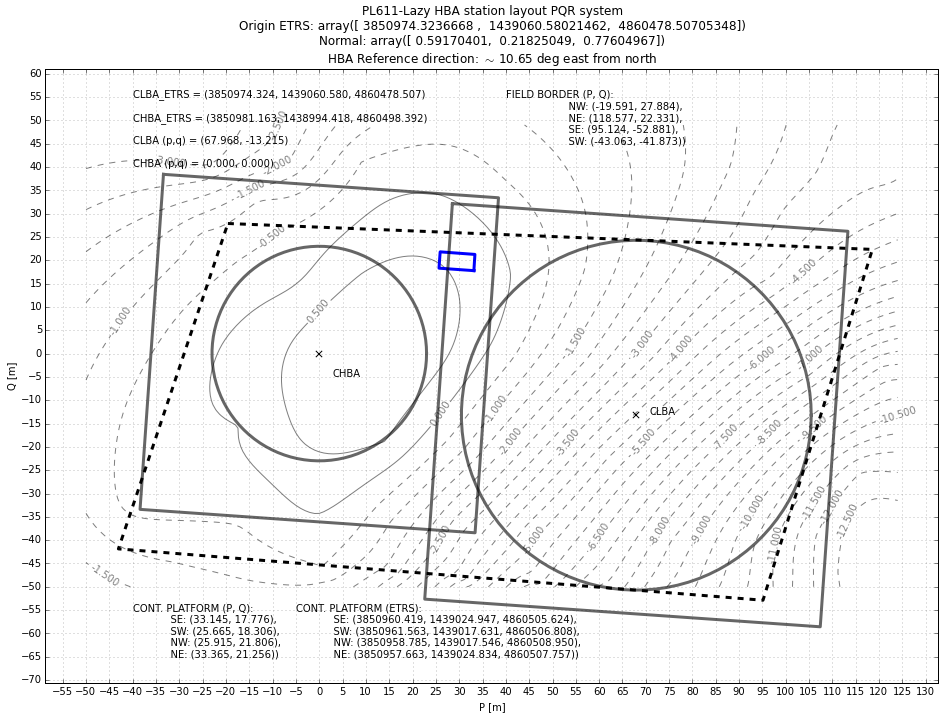

In [23]:
figure(figsize=(16, 11))
#imshow(r_m, origin='lower', extent=(-150.5, 100.5, -55.5, 100.5), vmin=-4, vmax=+4, alpha=0.3)
grid(alpha=0.5)
#cb = colorbar()
#cb.set_label('Height deviation [m]')
#cnt = contour(p_m, q_m, r_m, levels=arange(-10.0, +10.0, 0.5), colors='black', alpha=0.3)
#cnt.clabel(inline=True)
axis('equal')
title('''HBA Deviations from best-fit plane
Origin ETRS: %r\nNormal: %r''' %
      (CHBA_ETRS, solution_hba['normal']))
xlabel('P [m]')
ylabel('Q [m]')
xticks(arange(-200, 200, 5))
yticks(arange(-200, 200, 5))

#scatter(station_pqr[:,0], station_pqr[:,1], alpha=0.5)
#scatter(selection_pqr[:,0], selection_pqr[:,1], color='red', alpha=0.3)

lba_box_width_m = 85.0
hba_box_width_m = 72

cnt = contour(p_m_hba, q_m_hba, r_m_hba, levels=arange(-25, 25, 0.5), colors='black', alpha=0.5)
cnt.clabel(inline=True)


#container_pqr = transform(container_pos_etrs, CLBA_ETRS, rotation_matrix.T)
container_pqr = concatenate([container_pqr_hba, container_pqr_hba[0,:].reshape((1,3))], axis=0)
border_pqr = transform(border_pos_etrs, CHBA_ETRS, rotation_matrix_hba.T)
border_pqr =  concatenate([border_pqr, border_pqr[0,:].reshape((1,3))], axis=0)
print(border_pqr)
plot(container_pqr[:,0], container_pqr[:,1], linewidth=3)
#plot(container_new_pqr_hba[:,0], container_new_pqr_hba[:,1], linewidth=3, color='red', alpha=0.5)

#container_new_pqr_hba = concatenate([container_new_pqr_hba, container_new_pqr_hba[0,:].reshape((1,3))], axis=0)

plot(border_pqr[:,0], border_pqr[:,1], linewidth=3, color='black', linestyle='--')
#rot_ccw_rad = arctan2((border_pqr[2]-border_pqr[1])[1], (border_pqr[2]-border_pqr[1])[0])
#rot_ccw_deg = rot_ccw_rad*180/pi
#print rot_ccw_deg
rot_ccw_rad=-4*pi/180.0 # -4
lba_square = square_corners(lba_box_width_m, angle_rad=rot_ccw_rad)
hba_square = square_corners(hba_box_width_m, angle_rad=rot_ccw_rad)

clba_pqr = transform([CLBA_ETRS], CHBA_ETRS, rotation_matrix_hba.T)[0]
chba_pqr = transform([CHBA_ETRS], CHBA_ETRS, rotation_matrix_hba.T)[0]

#scatter(new_chba_pqr[0], new_chba_pqr[1], color='black', s=40, marker='x')
#text(new_chba_pqr[0]+3, new_chba_pqr[1]-5, 'CHBA', color='black')
plot(hba_square[:,0]+chba_pqr[0], hba_square[:,1]+chba_pqr[1], linewidth=3, alpha=0.6, color='black')
hba_circle = circle_points(HBA_CIRCLE_DIAMETER)
plot(hba_circle[:,0]+chba_pqr[0], hba_circle[:,1]+chba_pqr[1], linewidth=3, alpha=0.6, color='black')

#scatter(new_clba_pqr[0], new_clba_pqr[1], color='black', s=40, marker='x')
#text(new_clba_pqr[0]+3, new_clba_pqr[1], 'CLBA', color='black')
plot(lba_square[:,0]+clba_pqr[0], lba_square[:,1]+clba_pqr[1], linewidth=3, alpha=0.6, color='black')
lba_circle = circle_points(LBA_CIRCLE_DIAMETER)
plot(lba_circle[:,0]+clba_pqr[0], lba_circle[:,1]+clba_pqr[1], linewidth=3, alpha=0.6, color='black')

#CHBA_ETRS = solution['mean']+(transform([new_chba_pqr], zeros(3), rotation_matrix)[0,:])
#CLBA_ETRS = solution['mean']+(transform([new_clba_pqr], zeros(3), rotation_matrix)[0,:])

scatter(chba_pqr[0], chba_pqr[1], color='black', s=40, marker='x')
text(chba_pqr[0]+3, chba_pqr[1]-5, 'CHBA', color='black')
scatter(clba_pqr[0], clba_pqr[1], color='black', s=40, marker='x')
text(clba_pqr[0]+3, clba_pqr[1], 'CLBA', color='black')


title(r'''PL611-Lazy HBA station layout PQR system
Origin ETRS: %r
Normal: %r
HBA Reference direction: $\sim$ 10.65 deg east from north''' %
      (CLBA_ETRS, solution_hba['normal']))
print(clba_pqr)
print(chba_pqr)
print(chba_pqr - clba_pqr)
lh=5
line=1
text(-40, 60-line*lh, 'CLBA_ETRS = (%.3f, %.3f, %.3f)' % (CLBA_ETRS[0], CLBA_ETRS[1], CLBA_ETRS[2]))
line+=1
text(-40, 60-line*lh, 'CHBA_ETRS = (%.3f, %.3f, %.3f)' % (CHBA_ETRS[0], CHBA_ETRS[1], CHBA_ETRS[2]))
line+=1
text(-40, 60-line*lh, 'CLBA (p,q) = (%.3f, %.3f)' % (clba_pqr[0], clba_pqr[1]))
line+=1
text(-40, 60-line*lh, 'CHBA (p,q) = (%.3f, %.3f)' % (chba_pqr[0], chba_pqr[1]))

line=25
text(-40, 60-line*lh,
     '''CONT. PLATFORM (P, Q):
            SE: (%.3f, %.3f),
            SW: (%.3f, %.3f),
            NW: (%.3f, %.3f),
            NE: (%.3f, %.3f))''' %
    tuple(container_pqr_hba[0:4,0:2].ravel()))

text(-5, 60-line*lh,
     '''CONT. PLATFORM (ETRS):
            SE: (%.3f, %.3f, %.3f),
            SW: (%.3f, %.3f, %.3f),
            NW: (%.3f, %.3f, %.3f),
            NE: (%.3f, %.3f, %.3f))''' %
    tuple(container_etrs[0:4,0:3].ravel()))

line = 3
text(40, 60-line*lh,
     '''FIELD BORDER (P, Q):
                    NW: (%.3f, %.3f),
                    NE: (%.3f, %.3f),
                    SE: (%.3f, %.3f),
                    SW: (%.3f, %.3f))''' %
    tuple(border_pqr[0:4,0:2].ravel()))

savefig('pl611-lazy-hba-station-overview-pqr-20150806.pdf')

[[ -86.61770369   42.70068446   -7.31058542]
 [  51.31877234   34.51880744    0.36177353]
 [  26.58570601  -40.44956312    0.81182775]
 [-111.56351892  -26.46767775   -3.79499437]
 [ -86.61770369   42.70068446   -7.31058542]]
[ 0.  0.  0.]
[-67.80395647  14.68678804  -2.55406152]
[-67.80395647  14.68678804  -2.55406152]


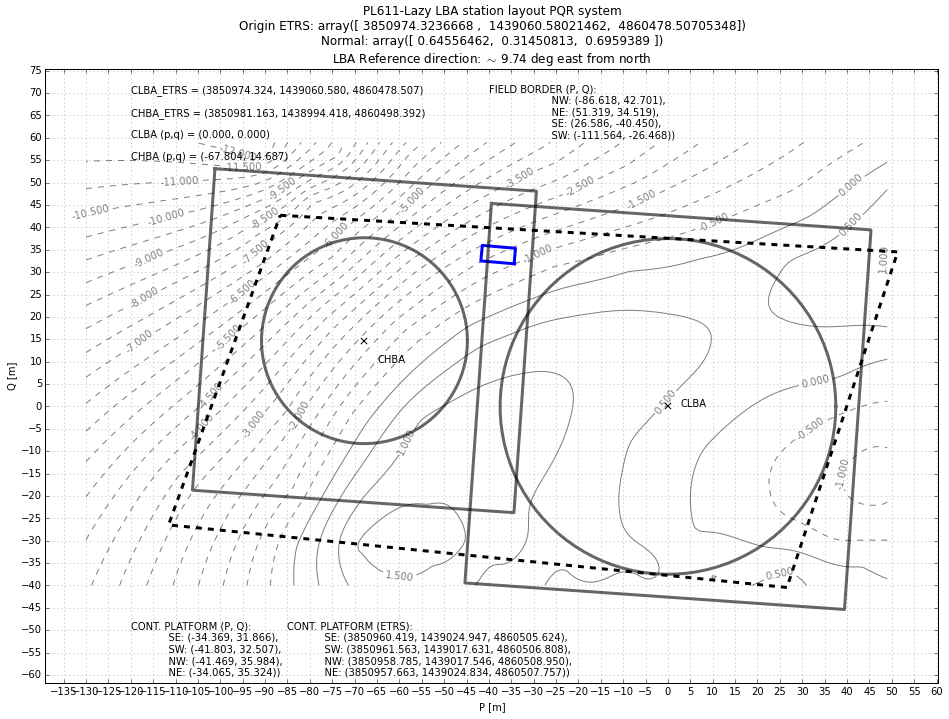

In [24]:
figure(figsize=(16, 11))
#imshow(r_m, origin='lower', extent=(-150.5, 100.5, -55.5, 100.5), vmin=-4, vmax=+4, alpha=0.3)
grid(alpha=0.5)
#cb = colorbar()
#cb.set_label('Height deviation [m]')
#cnt = contour(p_m, q_m, r_m, levels=arange(-10.0, +10.0, 0.5), colors='black', alpha=0.3)
#cnt.clabel(inline=True)
axis('equal')
title('''LBA Deviations from best-fit plane
Origin ETRS: %r\nNormal: %r''' %
      (CLBA_ETRS, solution_lba['normal']))
xlabel('P [m]')
ylabel('Q [m]')
xticks(arange(-200, 200, 5))
yticks(arange(-200, 200, 5))

#scatter(station_pqr[:,0], station_pqr[:,1], alpha=0.5)
#scatter(selection_pqr[:,0], selection_pqr[:,1], color='red', alpha=0.3)

lba_box_width_m = 85.0
hba_box_width_m = 72

cnt = contour(p_m_lba, q_m_lba, r_m_lba, levels=arange(-25, 25, 0.5), colors='black', alpha=0.5)
cnt.clabel(inline=True)


#container_pqr = transform(container_pos_etrs, CLBA_ETRS, rotation_matrix.T)
container_pqr = concatenate([container_pqr_lba, container_pqr_lba[0,:].reshape((1,3))], axis=0)
border_pqr = transform(border_pos_etrs, CLBA_ETRS, rotation_matrix_lba.T)
border_pqr =  concatenate([border_pqr, border_pqr[0,:].reshape((1,3))], axis=0)
print(border_pqr)
plot(container_pqr[:,0], container_pqr[:,1], linewidth=3)
#plot(container_new_pqr_lba[:,0], container_new_pqr_lba[:,1], linewidth=3, color='red', alpha=0.5)
plot(border_pqr[:,0], border_pqr[:,1], linewidth=3, color='black', linestyle='--')
#rot_ccw_rad = arctan2((border_pqr[2]-border_pqr[1])[1], (border_pqr[2]-border_pqr[1])[0])
#rot_ccw_deg = rot_ccw_rad*180/pi
#print rot_ccw_deg
rot_ccw_rad=-4*pi/180.0 # -4
lba_square = square_corners(lba_box_width_m, angle_rad=rot_ccw_rad)
hba_square = square_corners(hba_box_width_m, angle_rad=rot_ccw_rad)

clba_pqr = transform([CLBA_ETRS], CLBA_ETRS, rotation_matrix_lba.T)[0]
chba_pqr = transform([CHBA_ETRS], CLBA_ETRS, rotation_matrix_lba.T)[0]

#scatter(new_chba_pqr[0], new_chba_pqr[1], color='black', s=40, marker='x')
#text(new_chba_pqr[0]+3, new_chba_pqr[1]-5, 'CHBA', color='black')
plot(hba_square[:,0]+chba_pqr[0], hba_square[:,1]+chba_pqr[1], linewidth=3, alpha=0.6, color='black')
hba_circle = circle_points(HBA_CIRCLE_DIAMETER)
plot(hba_circle[:,0]+chba_pqr[0], hba_circle[:,1]+chba_pqr[1], linewidth=3, alpha=0.6, color='black')

#scatter(new_clba_pqr[0], new_clba_pqr[1], color='black', s=40, marker='x')
#text(new_clba_pqr[0]+3, new_clba_pqr[1], 'CLBA', color='black')
plot(lba_square[:,0]+clba_pqr[0], lba_square[:,1]+clba_pqr[1], linewidth=3, alpha=0.6, color='black')
lba_circle = circle_points(LBA_CIRCLE_DIAMETER)
plot(lba_circle[:,0]+clba_pqr[0], lba_circle[:,1]+clba_pqr[1], linewidth=3, alpha=0.6, color='black')

#CHBA_ETRS = solution['mean']+(transform([new_chba_pqr], zeros(3), rotation_matrix)[0,:])
#CLBA_ETRS = solution['mean']+(transform([new_clba_pqr], zeros(3), rotation_matrix)[0,:])

scatter(chba_pqr[0], chba_pqr[1], color='black', s=40, marker='x')
text(chba_pqr[0]+3, chba_pqr[1]-5, 'CHBA', color='black')
scatter(clba_pqr[0], clba_pqr[1], color='black', s=40, marker='x')
text(clba_pqr[0]+3, clba_pqr[1], 'CLBA', color='black')


title(r'''PL611-Lazy LBA station layout PQR system
Origin ETRS: %r
Normal: %r
LBA Reference direction: $\sim$ 9.74 deg east from north''' %
      (CLBA_ETRS, solution_lba['normal']))
print(clba_pqr)
print(chba_pqr)
print(chba_pqr - clba_pqr)
lh=5
line=-2
text(-120, 60-line*lh, 'CLBA_ETRS = (%.3f, %.3f, %.3f)' % (CLBA_ETRS[0], CLBA_ETRS[1], CLBA_ETRS[2]))
line+=1
text(-120, 60-line*lh, 'CHBA_ETRS = (%.3f, %.3f, %.3f)' % (CHBA_ETRS[0], CHBA_ETRS[1], CHBA_ETRS[2]))
line+=1
text(-120, 60-line*lh, 'CLBA (p,q) = (%.3f, %.3f)' % (clba_pqr[0], clba_pqr[1]))
line+=1
text(-120, 60-line*lh, 'CHBA (p,q) = (%.3f, %.3f)' % (chba_pqr[0], chba_pqr[1]))

line=24
text(-120, 60-line*lh,
     '''CONT. PLATFORM (P, Q):
            SE: (%.3f, %.3f),
            SW: (%.3f, %.3f),
            NW: (%.3f, %.3f),
            NE: (%.3f, %.3f))''' %
    tuple(container_pqr_lba[0:4,0:2].ravel()))

text(-85, 60-line*lh,
     '''CONT. PLATFORM (ETRS):
            SE: (%.3f, %.3f, %.3f),
            SW: (%.3f, %.3f, %.3f),
            NW: (%.3f, %.3f, %.3f),
            NE: (%.3f, %.3f, %.3f))''' %
    tuple(container_etrs[0:4,0:3].ravel()))


line = 0
text(-40, 60-line*lh,
     '''FIELD BORDER (P, Q):
                    NW: (%.3f, %.3f),
                    NE: (%.3f, %.3f),
                    SE: (%.3f, %.3f),
                    SW: (%.3f, %.3f))''' %
    tuple(border_pqr[0:4,0:2].ravel()))

savefig('pl611-lazy-lba-station-overview-pqr-20150806.pdf')

## ETRS field corners

We still do not have field corners in ETRS coordinates. In the following cells, I'll try to derive them by interpolating from printouts.

I need to solve for the ETRS XYZ coordinates using a non-linear penalty function:
\begin{equation}
f(\mathbf{x}) = \sum_k  \left(\| \mathbf{x} - \mathbf{x}_k \| - d_k\right)^2
\end{equation}

In [25]:
from scipy.optimize import fmin_l_bfgs_b

def penalty_function(etrs, refpoints_etrs, refpoints_distances):
    calculated_distances = sqrt(((refpoints_etrs - etrs[newaxis,:])**2).sum(axis=1))
    return ((calculated_distances - refpoints_distances)**2).sum()

def gen_penalty_fn(refpoints_etrs, refpoints_distances):
    def penalty(x0):
        return penalty_function(x0, refpoints_etrs, refpoints_distances)
    return penalty

def fit_etrs(refpoints_etrs, refpoints_distances):
    p_fn = gen_penalty_fn(refpoints_etrs, refpoints_distances)
    x0 = refpoints_etrs.mean(axis=0)
    etrs, penalty, info_dict = fmin_l_bfgs_b(p_fn, x0, fprime=None, approx_grad=True)
    print(etrs, sqrt(penalty)/sqrt(len(refpoints_distances)-len(etrs)))
    return etrs


In [26]:
def get_etrs(names, position_dictionary):
    return array([position_dictionary[name] for name in names])
pd = position_dict

refpoints_dict = {
    'REF_NE': (get_etrs(['1', '2', '19', '20'], pd), array([14.85, 18.45, 9.98, 7.50])*norm(pd['2'] - pd['20'])/25.75),
    'REF_SE': (get_etrs(['43', '44', '71', '72'], pd), array([25.50, 2.20, 19.45, 25.40])*norm(pd['72'] - pd['44'])/23.38),
    'REF_NW': (get_etrs(['11', '12', '31', '32'], pd), array([14.88, 24.65, 10.20, 12.75])*norm(pd['31'] - pd['32'])/22.85),
    'REF_SW': (get_etrs(['57', '58', '59', '64'], pd), array([29.90, 12.50, 10.63, 30.23])*norm(pd['59'] - pd['64'])/26.00)
}

container_dict = {
    'CNT_NE': (get_etrs(['6', '7', '14', '15'], pd), array([19.80, 28.55, 22.10, 6.15])*norm(pd['14'] - pd['7'])/25.05),
    'CNT_SE': (get_etrs(['6', '7', '14', '15'], pd), array([23.55, 31.15, 21.38, 3.48])*norm(pd['14'] - pd['7'])/25.05),
    'CNT_SW': (get_etrs(['6', '7', '14', '15'], pd), array([23.70, 26.63, 13.25, 5.23])*norm(pd['14'] - pd['7'])/25.05),
    'CNT_NW': (get_etrs(['6', '7', '14', '15'], pd), array([20.0, 23.1,14.37, 7.30])*norm(pd['14'] - pd['7'])/25.05)
}

In [27]:
container_dict

{'CNT_NE': (array([[ 3850940.759,  1439031.8  ,  4860517.774],
         [ 3850944.066,  1439016.315,  4860520.197],
         [ 3850962.756,  1439017.732,  4860506.594],
         [ 3850958.977,  1439033.733,  4860504.182]]),
  array([ 18.30576646,  26.39543598,  20.43219388,   5.68588201])),
 'CNT_NW': (array([[ 3850940.759,  1439031.8  ,  4860517.774],
         [ 3850944.066,  1439016.315,  4860520.197],
         [ 3850962.756,  1439017.732,  4860506.594],
         [ 3850958.977,  1439033.733,  4860504.182]]),
  array([ 18.49067319,  21.35672754,  13.28554869,   6.74909572])),
 'CNT_SE': (array([[ 3850940.759,  1439031.8  ,  4860517.774],
         [ 3850944.066,  1439016.315,  4860520.197],
         [ 3850962.756,  1439017.732,  4860506.594],
         [ 3850958.977,  1439033.733,  4860504.182]]),
  array([ 21.77276768,  28.7992235 ,  19.76652964,   3.21737714])),
 'CNT_SW': (array([[ 3850940.759,  1439031.8  ,  4860517.774],
         [ 3850944.066,  1439016.315,  4860520.197],
        

In [28]:
print('Border')
border_names = refpoints_dict.keys()
print(border_names)
border_etrs = array([fit_etrs(*(refpoints_dict[name])) for name in border_names])

print('Container')
container_names = container_dict.keys()
print(container_names)
container_etrs = array([fit_etrs(*(container_dict[name])) for name in container_names])
print(container_names)

Border
dict_keys(['REF_SW', 'REF_NE', 'REF_NW', 'REF_SE'])
[ 3851021.83304835  1438956.18327832  4860476.16247287] 0.0578735335109
[ 3850935.69297659  1439106.25345331  4860494.22075393] 0.0048460944886
[ 3850963.43091107  1438972.73686714  4860517.80481272] 0.0528411157804
[ 3850996.1796777   1439089.43361229  4860446.36016848] 0.0420066162982
Container
dict_keys(['CNT_NE', 'CNT_SW', 'CNT_NW', 'CNT_SE'])
[ 3850954.4760421   1439036.37381132  4860506.52933412] 0.0533540869085
[ 3850958.22818569  1439029.00418392  4860504.704619  ] 0.133918322117
[ 3850955.33341286  1439028.71617932  4860506.88378981] 0.0646598929048
[ 3850957.3067425   1439036.53349932  4860504.46239901] 0.102751283125
dict_keys(['CNT_NE', 'CNT_SW', 'CNT_NW', 'CNT_SE'])


In [29]:
container_names

dict_keys(['CNT_NE', 'CNT_SW', 'CNT_NW', 'CNT_SE'])

In [30]:
container_etrs

array([[ 3850954.4760421 ,  1439036.37381132,  4860506.52933412],
       [ 3850958.22818569,  1439029.00418392,  4860504.704619  ],
       [ 3850955.33341286,  1439028.71617932,  4860506.88378981],
       [ 3850957.3067425 ,  1439036.53349932,  4860504.46239901]])

## Another container shift 2015-08-06

Michiel.
 
De locatie/positie van de Lazy PL611 container platform is enigzins naar links verplaatst.
 
<pre>
Uitgaande van de Station lLayout HBA tekening HBA (P,Q ==>> 0,0) zijn de PQ posities als volgt:
REF_NW ==>> 25.9154, 21.8061
REF_SW ==>> 25.6654, 18.3061
REF_SE ==>> 33.1454, 17.7761
REF_NE ==>> 33.3654, 21.2561
</pre>

Zou je uitgaande van deze info 2 nieuwe PQR positie tekeningen (LBA en HBA) willen maken, waarbij in de LBA positie tekening de juist positie (PQ) locatie van de container is aangegeven.
 
Eim
 
 

In [31]:
container_names = ['CNT_NW', 'CNT_SW', 'CNT_SE', 'CNT_NE']
container_20150806_hba_pqr=array([[33.1454, 17.7761, 0.0],
                              [25.6654, 18.3061, 0.0],
                              [25.9154, 21.8061, 0.0],
                              [33.3654, 21.2561, 0.0]])

container_20150806_etrs = transform(container_20150806_hba_pqr, zeros(3), rotation_matrix_hba) + CHBA_ETRS[newaxis,:]

In [32]:
transform(container_20150806_etrs, CHBA_ETRS, rotation_matrix_hba.T)

array([[  3.31454000e+01,   1.77761000e+01,  -2.84308577e-10],
       [  2.56654000e+01,   1.83061000e+01,   4.03557188e-10],
       [  2.59154000e+01,   2.18061000e+01,  -3.06799919e-10],
       [  3.33654000e+01,   2.12561000e+01,  -2.99609226e-10]])

In [33]:
container_20150806_etrs

array([[ 3850960.41876731,  1439024.94680262,  4860505.62358072],
       [ 3850961.56318043,  1439017.63121466,  4860506.80839774],
       [ 3850958.78529467,  1439017.54563432,  4860508.95048241],
       [ 3850957.66270317,  1439024.83395785,  4860507.756695  ]])

In [34]:
CHBA_ETRS

array([ 3850981.16319719,  1438994.41834461,  4860498.39245684])

In [35]:
CLBA_ETRS


array([ 3850974.3236668 ,  1439060.58021462,  4860478.50705348])

After projection onto flattened surface per the pl611-lba-solution.lisp file:

In [36]:
CLBA_ETRS = array([3850974.511, 1439060.669, 4860478.711])

# Final flattening survey of HBA field

In [40]:
CHBA_ETRS = array([3850981.388,1438994.501, 4860498.687])
hba_stake_names, hba_stakes_etrs = read_etrs_csv('pl611-hba-stakes-etrs.csv', delimiter=';')
hba_rotation_matrix = array([[-0.20792348993213333, -0.7795739547464944, 0.5907895322493053],
                             [0.9714305370448002, -0.09392701512269133, 0.21794592798901527],
                             [-0.11441387167338307, 0.6192270705573623, 0.7768315783087439]])

CLBA_ETRS = array([3850974.511, 1439060.669, 4860478.711])
lba_stake_names, lba_stakes_etrs = read_etrs_csv('pl611-lba-stakes-etrs.csv', delimiter=';')
lba_rotation_matrix = array([[-0.27336814043997193, -0.715243266964909, 0.643192761816981],
                             [0.9477993700899157, -0.08617612831160104, 0.3070016758364383],
                             [-0.16415301961752288, 0.6935421717318899, 0.701464925837253]])
MEAN_ETRS = CHBA_ETRS*0.5+CLBA_ETRS*0.5
geo_mean = geographic_from_xyz(MEAN_ETRS)
ellipsoid_normal = normal_vector_ellipsoid(geo_mean['lon_rad'], geo_mean['lat_rad'])
local_north_projection = projection_matrix(MEAN_ETRS, ellipsoid_normal)
hba_stakes_local = zip(hba_stake_names, transform(hba_stakes_etrs, MEAN_ETRS, local_north_projection.T))
lba_stakes_local = zip(lba_stake_names, transform(lba_stakes_etrs, MEAN_ETRS, local_north_projection.T))

[[  3.66512781  24.16716537   1.80085054]
 [ -3.58823137  26.06914653   1.75036944]
 [ -2.69603219  29.46232605   1.69732824]
 [  4.52414903  27.54623095   1.74795111]
 [  3.66512781  24.16716537   1.80085054]]


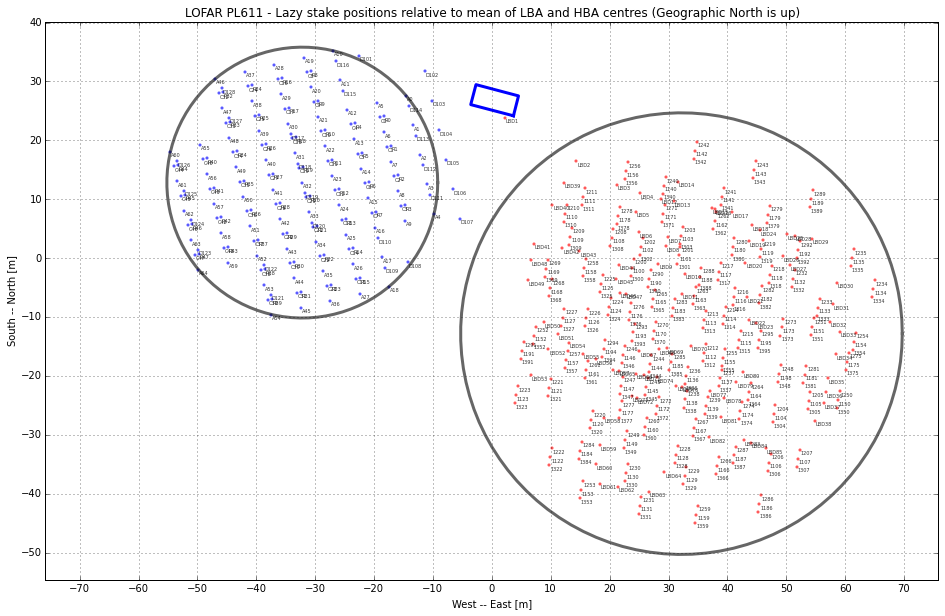

In [41]:
figure(figsize=(16,10))


for name, pqr in lba_stakes_local:
    scatter(pqr[0], pqr[1], alpha=0.5, s=5, color='red')
    text(pqr[0]+.2, pqr[1]-.2, name, fontsize=5, alpha=0.8,
         verticalalignment='top')
for name, pqr in hba_stakes_local:
    scatter(pqr[0], pqr[1], alpha=0.5, s=5, color='blue')
    text(pqr[0]+.2, pqr[1]-.2, name, fontsize=5, alpha=0.8,
         verticalalignment='top')
container_local = transform(container_20150806_etrs, MEAN_ETRS, local_north_projection.T)
container_local = concatenate([container_local, container_local[0,:].reshape((1,3))], axis=0)
print(container_local)
#container_local = container_local[array([0, 1, 3, 2, 4])]
plot(container_local[:,0], container_local[:,1], linewidth=3)


chba_local = transform([CHBA_ETRS], MEAN_ETRS, local_north_projection.T)[0]
hba_circle = circle_points(HBA_CIRCLE_DIAMETER)
plot(hba_circle[:,0]+chba_local[0], hba_circle[:,1]+chba_local[1], linewidth=3, alpha=0.6, color='black')
clba_local = transform([CLBA_ETRS], MEAN_ETRS, local_north_projection.T)[0]
lba_circle = circle_points(LBA_CIRCLE_DIAMETER)
plot(lba_circle[:,0]+clba_local[0], lba_circle[:,1]+clba_local[1], linewidth=3, alpha=0.6, color='black')


xticks(arange(-150,170,10))
yticks(arange(-150, 80,10))
axis('equal')
grid()
xlim(-80,80)
xlabel('West -- East [m]')
ylabel('South -- North [m]')
title('LOFAR PL611 - Lazy stake positions relative to mean of LBA and HBA centres (Geographic North is up)')
savefig('pl611-stake-positions.pdf')